# 악성 데이터 심각도 분석 프로젝트

## 📋 분석 목표
**악성 데이터만을 대상으로 하여, 악성 내에서 어떤 특징이 악성의 심각도에 가장 큰 영향을 주는지 분석**

- 악성(M) 데이터만 필터링하여 분석
- KMeans 클러스터링으로 악성 데이터를 고악성/저악성으로 구분
- 고악성/저악성을 구분하는 데 중요한 특징 파악
- XAI 기법을 활용한 특징 중요도 분석

---


## 블록 1: 라이브러리 임포트 & 환경 설정

필요한 라이브러리들을 임포트하고 한글 폰트를 설정합니다.

**주요 라이브러리:**
- `pandas`, `numpy`: 데이터 처리
- `matplotlib`, `seaborn`: 시각화
- `sklearn`: 머신러닝 모델 및 전처리
- `shap`, `lime`: XAI (설명 가능한 AI) 분석 도구


In [32]:
# ============================================
# 블록 1. 라이브러리 임포트 & 환경 설정
# ============================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rcParams

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import shap
from lime.lime_tabular import LimeTabularExplainer

print("✅ 라이브러리 임포트 완료")

# --------------------------------------------
# 한글 폰트 설정 (윈도우: Malgun Gothic)
# --------------------------------------------
selected_font = None
try:
    font_names = [f.name for f in font_manager.fontManager.ttflist]
    if "Malgun Gothic" in font_names:
        rcParams["font.family"] = "Malgun Gothic"
        selected_font = "Malgun Gothic"
        print("✅ 한글 폰트 설정: Malgun Gothic")
    else:
        print("⚠️ 'Malgun Gothic' 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
except Exception as e:
    print(f"⚠️ 폰트 설정 중 오류 발생: {e}")

# 마이너스 깨짐 방지
rcParams["axes.unicode_minus"] = False


✅ 라이브러리 임포트 완료
✅ 한글 폰트 설정: Malgun Gothic


## 블록 2: 데이터 로드 & 악성 심각도 정의

**핵심 단계:**

1. **데이터 로드**: 유방암 진단 데이터셋 로드
2. **악성 데이터 필터링**: 진단이 "M"(악성)인 데이터만 추출
3. **악성 심각도 정의**: 
   - KMeans 클러스터링으로 악성 데이터를 2개 그룹으로 분류
   - 특징 값들의 합이 더 큰 클러스터를 "고악성(1)"으로 정의
   - 나머지 클러스터를 "저악성(0)"으로 정의
4. **데이터 준비**: 악성 데이터만으로 모델 학습용 데이터셋 구성

**결과**: 악성 데이터 내에서 고악성/저악성을 구분하는 타겟 변수 생성


In [33]:
# ============================================
# 블록 2. 데이터 로드 & 악성 데이터 필터링
# ============================================
data_path = "../data/kr_data.csv"  # 파일 이름/경로만 맞게 수정

df = pd.read_csv(data_path, encoding="utf-8")

print("=" * 70)
print("원본 데이터 정보")
print("=" * 70)
print(f"전체 데이터 shape: {df.shape}")
print("\n컬럼 정보:")
print(df.columns)

# -----------------------------
# 진단 컬럼 및 특징 컬럼 설정
# -----------------------------
# 보통 형식: [ID, diagnosis, feature1, feature2, ...]
target_col = df.columns[1]      # 진단 컬럼 (M/B)
feature_cols = list(df.columns[2:])  # 수치형 특징 컬럼들

print("\n진단 분포:")
print(df[target_col].value_counts())

# -----------------------------
# 악성 데이터만 필터링 (분석의 핵심!)
# -----------------------------
df_malignant = df[df[target_col] == "M"].copy()
print("\n악성(M) 데이터 개수:", len(df_malignant))

# -----------------------------
# 악성 데이터 내에서 악성 심각도 정의
# 방법: KMeans 클러스터링으로 악성 데이터를 2개 그룹으로 분류
#       더 악성인 그룹(클러스터)을 타겟으로 설정
# -----------------------------
X_malig = df_malignant[feature_cols].values

# 스케일링 (악성 데이터만으로 fit)
scaler = StandardScaler()
X_malig_scaled = scaler.fit_transform(X_malig)

# KMeans로 악성 데이터를 2개 클러스터로 분류
kmeans_malig = KMeans(n_clusters=2, random_state=42, n_init=10)
malig_clusters = kmeans_malig.fit_predict(X_malig_scaled)

# 각 클러스터의 특징 평균을 계산하여 더 악성인 클러스터 결정
cluster_means = []
for cluster_id in range(2):
    cluster_data = X_malig_scaled[malig_clusters == cluster_id]
    cluster_mean = cluster_data.mean(axis=0)
    cluster_means.append(cluster_mean)

# 특징 값들의 합이 더 큰 클러스터를 "고악성"으로 정의
cluster_sums = [cm.sum() for cm in cluster_means]
high_malignant_cluster = np.argmax(cluster_sums)

# 타겟 변수 생성: 고악성 클러스터 = 1, 저악성 클러스터 = 0
df_malignant["악성_심각도"] = (malig_clusters == high_malignant_cluster).astype(int)

print("\n악성 심각도 분포:")
print(df_malignant["악성_심각도"].value_counts())
print(f"  - 고악성 (1): {df_malignant['악성_심각도'].sum()}개")
print(f"  - 저악성 (0): {(df_malignant['악성_심각도'] == 0).sum()}개")

# 모델 학습용 데이터 준비 (악성 데이터만 사용)
X = X_malig_scaled
y = df_malignant["악성_심각도"].values

print("\n✅ 데이터 전처리 완료 (악성 데이터만 사용)")
print(f"X_scaled shape: {X.shape}, y shape: {y.shape}")
print("분석 목표: 악성 데이터 내에서 어떤 특징이 악성 심각도에 영향을 주는지 분석")


원본 데이터 정보
전체 데이터 shape: (569, 32)

컬럼 정보:
Index(['id', '진단', '반경 평균', '조직 평균', '둘레 길이 평균', '면적 평균', '매끄러움 평균', '치밀도 평균',
       '오목함 평균', '오목한 포인트 개수 평균', '좌우 대칭도 평균', '경계 불규칙성 평균', '반경 표준오차',
       '조직 표준오차', '둘레 길이 표준오차', '면적 표준오차', '매끄러움 표준오차', '치밀도 표준오차', '오목함 표준오차',
       '오목한 포인트 개수 표준오차', '좌우 대칭도 표준오차 ', '경계 불규칙성 표준오차', '반경 최악상태', '조직 최악상태',
       '둘레 길이 최악상태', '면적 최악상태', '매끄러움 최악상태', '치밀도 최악상태', '오목함 최악상태',
       '오목한 포인트 개수 최악상태', '대칭성 최악상태', '경계 불규칙성 최악상태'],
      dtype='object')

진단 분포:
진단
B    357
M    212
Name: count, dtype: int64

악성(M) 데이터 개수: 212

악성 심각도 분포:
악성_심각도
0    156
1     56
Name: count, dtype: int64
  - 고악성 (1): 56개
  - 저악성 (0): 156개

✅ 데이터 전처리 완료 (악성 데이터만 사용)
X_scaled shape: (212, 30), y shape: (212,)
분석 목표: 악성 데이터 내에서 어떤 특징이 악성 심각도에 영향을 주는지 분석


## 블록 3: 모델 학습 (악성 심각도 예측)

**목적**: 악성 데이터만을 사용하여 고악성/저악성을 구분하는 모델 학습

**사용 모델**: RandomForest Classifier
- 악성 데이터만으로 학습 (전체 데이터 사용 X)
- 고악성(1) vs 저악성(0) 분류 모델
- Train/Test 분리 시 stratify 옵션으로 클래스 비율 유지

**평가 지표**: 정확도, 혼동행렬, 분류 리포트


In [34]:
# ============================================
# 블록 3. Train/Test 분리 & RandomForest 학습
# (악성 데이터만 사용하여 악성 심각도 예측)
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print("=" * 70)
print("RandomForest 성능 (악성 심각도 예측 모델)")
print("=" * 70)
print("정확도(accuracy):", accuracy_score(y_test, y_pred))
print("\n혼동행렬:")
print(confusion_matrix(y_test, y_pred))
print("\n분류 리포트:")
print(classification_report(y_test, y_pred, target_names=["저악성", "고악성"]))
print("\n✅ 랜덤포레스트 학습 및 평가 완료")
print("   (악성 데이터 내에서 고악성/저악성을 구분하는 모델)")


RandomForest 성능 (악성 심각도 예측 모델)
정확도(accuracy): 0.9534883720930233

혼동행렬:
[[31  1]
 [ 1 10]]

분류 리포트:
              precision    recall  f1-score   support

         저악성       0.97      0.97      0.97        32
         고악성       0.91      0.91      0.91        11

    accuracy                           0.95        43
   macro avg       0.94      0.94      0.94        43
weighted avg       0.95      0.95      0.95        43


✅ 랜덤포레스트 학습 및 평가 완료
   (악성 데이터 내에서 고악성/저악성을 구분하는 모델)


## 블록 4: 시각화 1 - 고악성 vs 저악성 특징 분포 비교

**목적**: 주요 특징들의 분포를 고악성과 저악성으로 구분하여 비교

**시각화 내용**:
- 주요 특징 6개의 히스토그램
- 고악성(빨간색)과 저악성(파란색)의 분포 차이 확인
- KDE 커브로 분포 형태 파악

**인사이트**: 어떤 특징에서 고악성과 저악성의 분포 차이가 큰지 확인


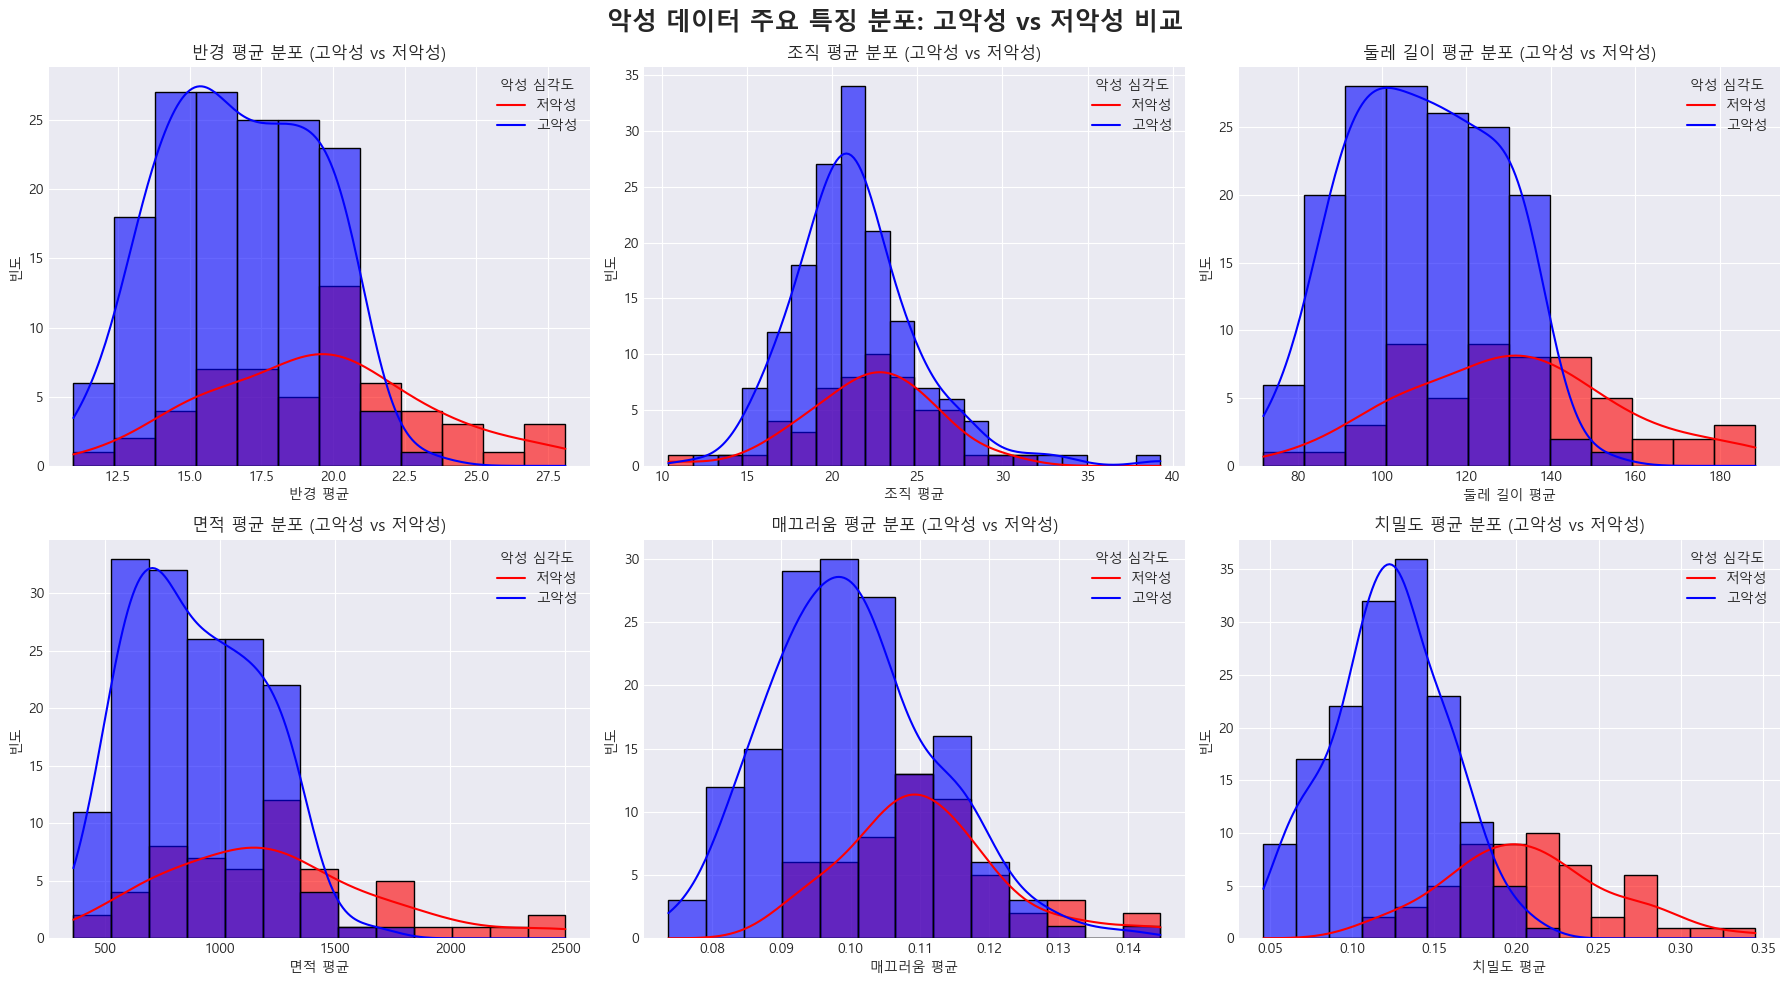

✅ 시각화 1 완료: 고악성 vs 저악성 특징 분포 비교


In [35]:
# ============================================
# 블록 4. 시각화 1: 주요 특징 분포 (고악성 vs 저악성 비교)
# ============================================

# 주요 특징 6개 선택 (앞에서 6개 사용)
main_features = feature_cols[:6]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(main_features):
    ax = axes[i]
    # 고악성과 저악성을 구분하여 시각화
    sns.histplot(
        data=df_malignant,
        x=col,
        hue="악성_심각도",
        kde=True,
        ax=ax,
        alpha=0.6,
        palette={0: "blue", 1: "red"}
    )
    ax.set_title(f"{col} 분포 (고악성 vs 저악성)")
    ax.set_xlabel(col)
    ax.set_ylabel("빈도")
    ax.legend(title="악성 심각도", labels=["저악성", "고악성"])

# 남는 subplot 비우기
for j in range(len(main_features), len(axes)):
    axes[j].axis("off")

plt.suptitle("악성 데이터 주요 특징 분포: 고악성 vs 저악성 비교", fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()

print("✅ 시각화 1 완료: 고악성 vs 저악성 특징 분포 비교")


## 블록 5: 시각화 2 - 상관관계 분석

**목적**: 특징 간 상관관계 및 악성 심각도와의 상관관계 분석

**시각화 내용**:
1. **특징 간 상관관계 히트맵**: 모든 특징들 간의 상관계수
2. **악성 심각도 상관관계 바 차트**: 각 특징이 악성 심각도와 얼마나 상관관계가 있는지

**인사이트**: 
- 어떤 특징이 악성 심각도와 가장 높은 상관관계를 가지는지 파악
- 특징들 간의 다중공선성 확인


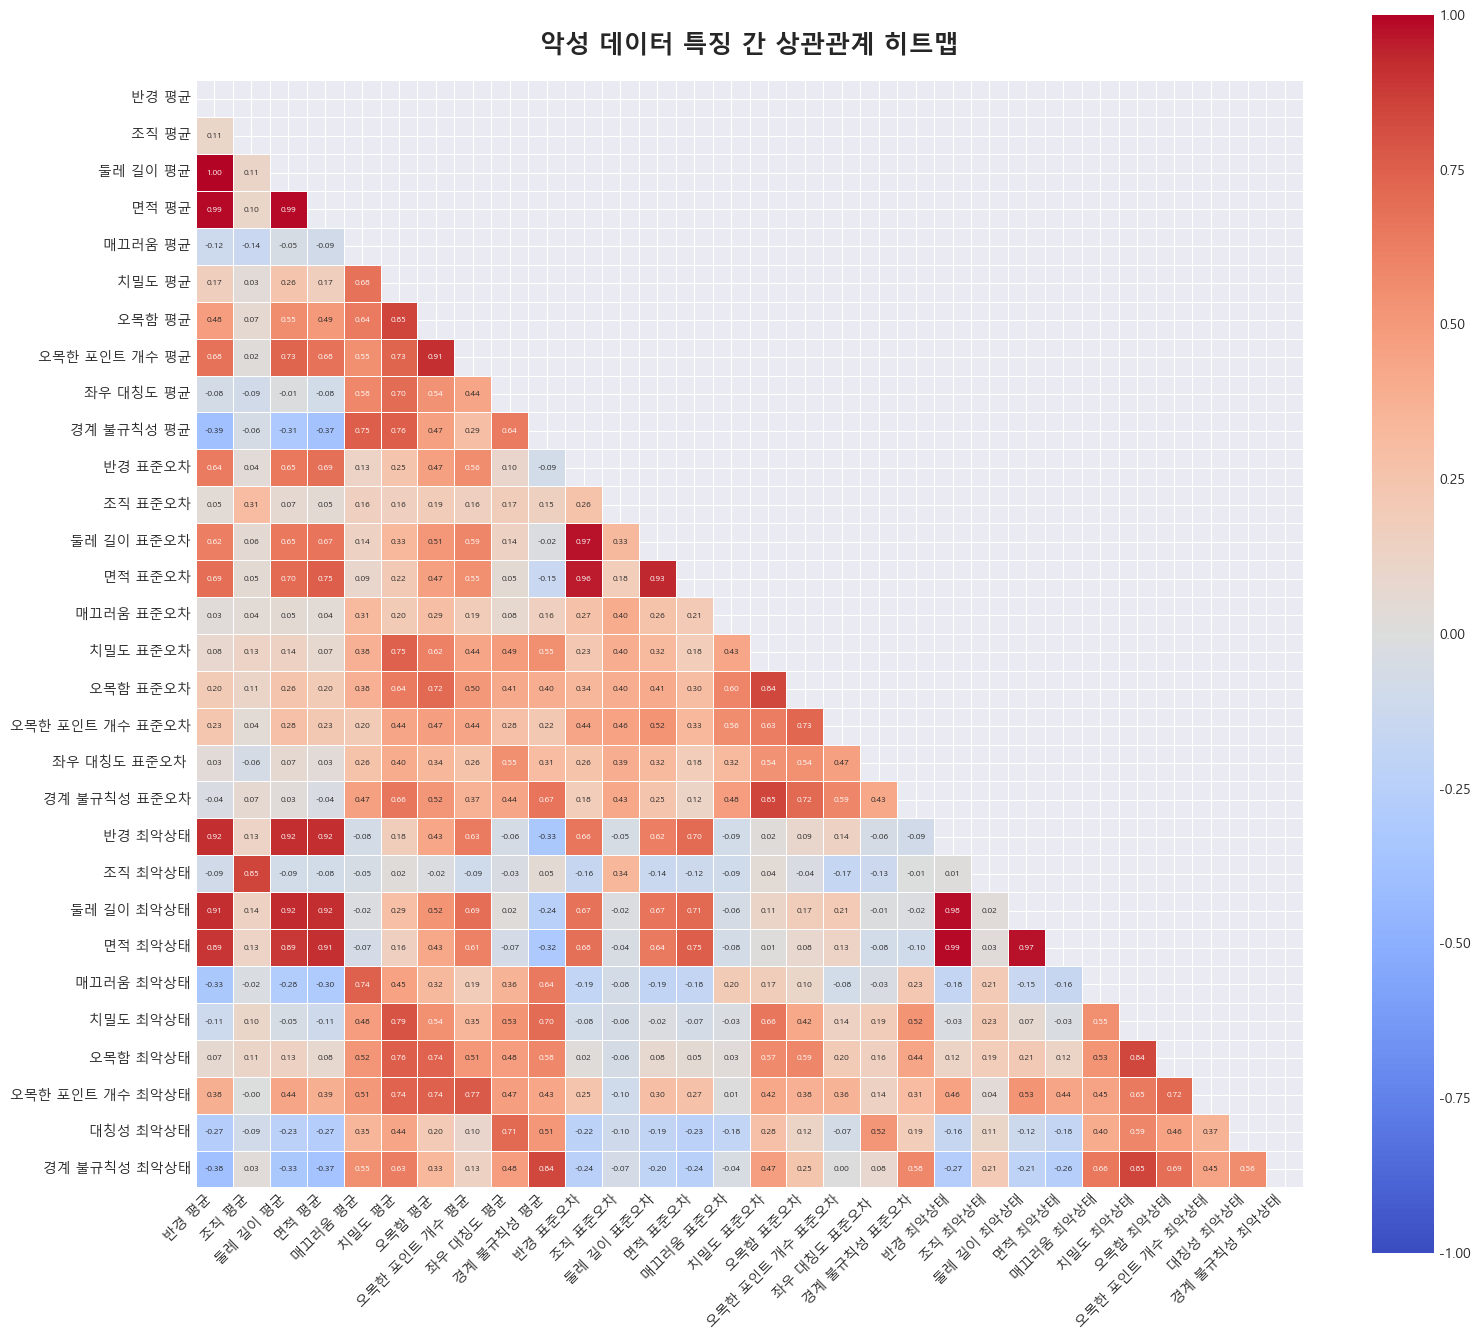

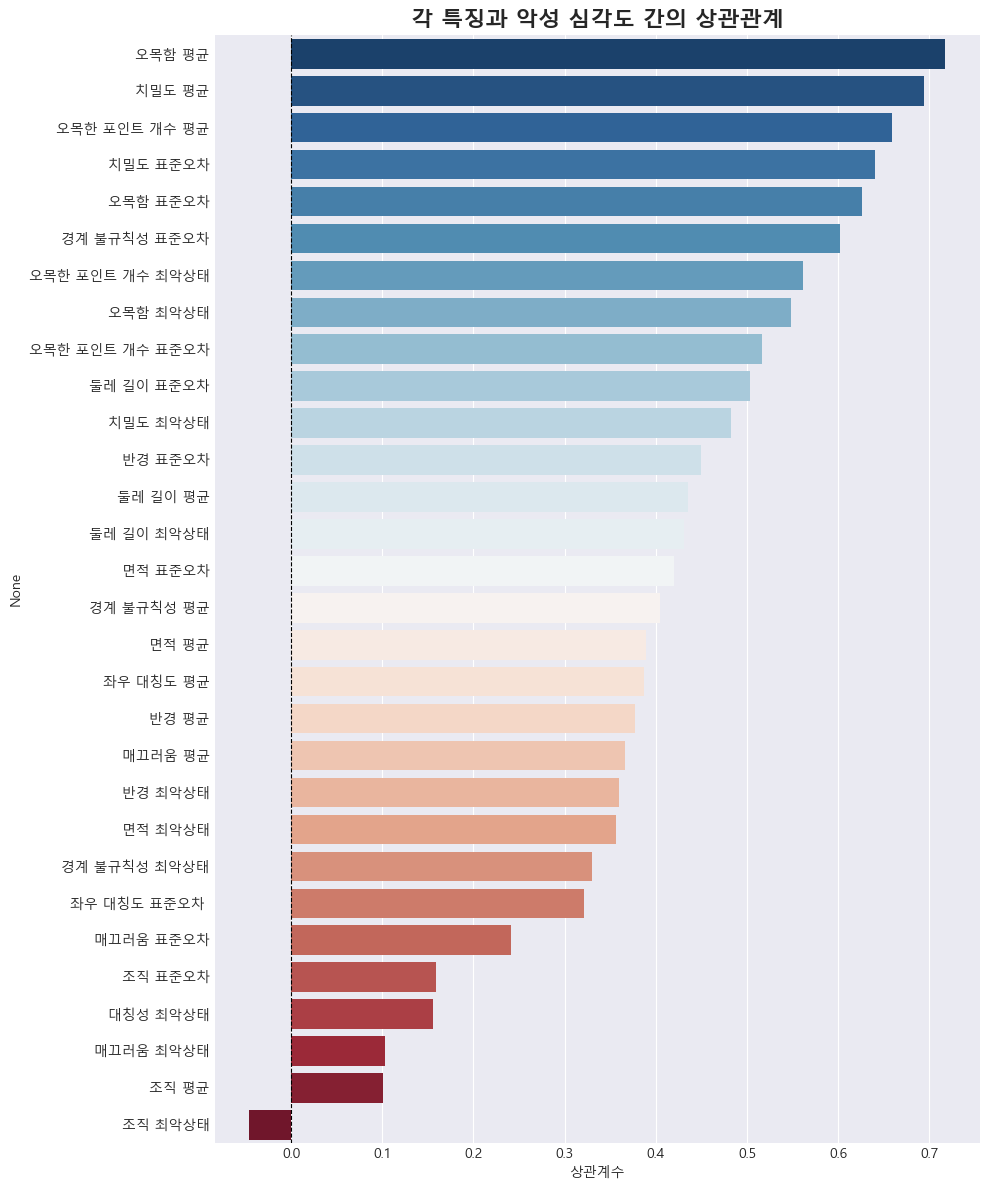

✅ 시각화 2 완료: 상관관계 히트맵 및 악성 심각도 상관관계


In [36]:
# ============================================
# 블록 5. 시각화 2: 특징 간 상관관계 히트맵 (악성 데이터)
# ============================================
correlation_matrix = df_malignant[feature_cols].corr()

num_features = len(feature_cols)
fig_size = max(16, num_features * 0.5)

plt.figure(figsize=(fig_size, fig_size))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

annot_size = max(6, min(10, 200 // num_features)) if num_features > 0 else 8

sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    vmin=-1,
    vmax=1,
    annot_kws={"size": annot_size},
)

plt.title("악성 데이터 특징 간 상관관계 히트맵", fontsize=18, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 추가: 각 특징과 악성 심각도 간의 상관관계
malig_severity_corr = df_malignant[feature_cols + ["악성_심각도"]].corr()["악성_심각도"].drop("악성_심각도").sort_values(ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(
    x=malig_severity_corr.values,
    y=malig_severity_corr.index,
    orient="h",
    palette="RdBu_r"
)
plt.title("각 특징과 악성 심각도 간의 상관관계", fontsize=16, fontweight="bold")
plt.xlabel("상관계수")
plt.axvline(x=0, color="black", linestyle="--", linewidth=0.8)
plt.tight_layout()
plt.show()

print("✅ 시각화 2 완료: 상관관계 히트맵 및 악성 심각도 상관관계")


## 블록 6: 시각화 3 - 산점도 매트릭스

**목적**: 악성 심각도와 상관관계가 높은 특징들의 관계를 다차원적으로 시각화

**시각화 내용**:
- 악성 심각도와 상관관계가 높은 상위 5개 특징 선택
- Pair plot으로 특징들 간의 관계 및 고악성/저악성 구분 확인
- 대각선: 각 특징의 분포 (KDE)
- 비대각선: 특징 간 산점도

**인사이트**: 여러 특징을 동시에 고려했을 때 고악성/저악성의 구분 패턴 파악


산점도 매트릭스에 사용할 특징들 (악성 심각도와 상관관계 높은 순): ['오목함 평균', '치밀도 평균', '오목한 포인트 개수 평균', '치밀도 표준오차', '오목함 표준오차']


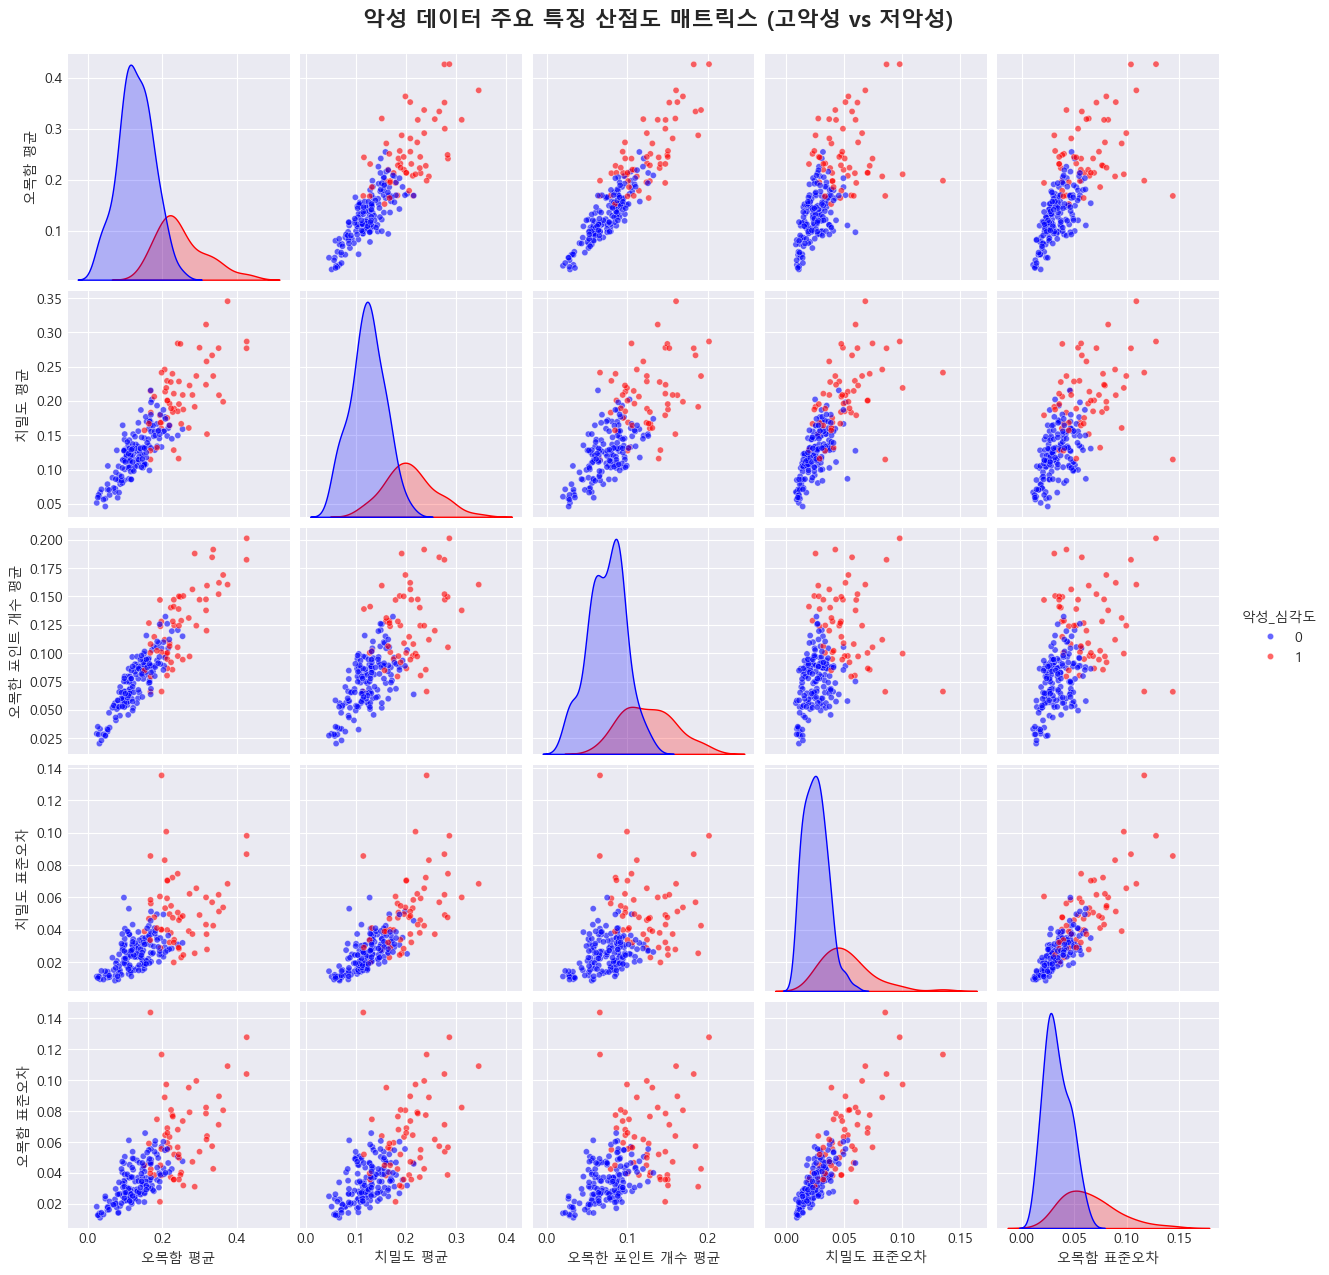

✅ 시각화 3 완료: 산점도 매트릭스 (고악성 vs 저악성)


In [37]:
# ============================================
# 블록 6. 시각화 3: 주요 특징 산점도 매트릭스 (고악성 vs 저악성)
# ============================================
if len(feature_cols) >= 5:
    # 악성 심각도와 상관관계 높은 순서대로 5개 선택
    corr_with_severity = df_malignant[feature_cols + ["악성_심각도"]].corr()["악성_심각도"].drop("악성_심각도").abs().sort_values(ascending=False)
    selected_features = list(corr_with_severity.index[:5])
else:
    selected_features = feature_cols

print("산점도 매트릭스에 사용할 특징들 (악성 심각도와 상관관계 높은 순):", selected_features)

sns.pairplot(
    df_malignant[selected_features + ["악성_심각도"]],
    hue="악성_심각도",
    diag_kind="kde",
    plot_kws={"alpha": 0.6, "s": 20},
    palette={0: "blue", 1: "red"}
)
plt.suptitle("악성 데이터 주요 특징 산점도 매트릭스 (고악성 vs 저악성)", y=1.02, fontsize=16, fontweight="bold")
plt.show()

print("✅ 시각화 3 완료: 산점도 매트릭스 (고악성 vs 저악성)")


## 블록 7: 시각화 4 - PCA 차원 축소

**목적**: 고차원 특징 공간을 2차원으로 축소하여 고악성/저악성의 분포 확인

**시각화 내용**:
- PCA로 30개 특징을 2개의 주성분(PC1, PC2)으로 축소
- 고악성과 저악성을 색상으로 구분하여 시각화
- 각 주성분에 기여하는 주요 특징 확인

**인사이트**: 
- 2차원 공간에서 고악성/저악성의 분리 가능 여부 확인
- 주성분에 기여하는 특징들이 악성 심각도에 중요한 특징일 가능성


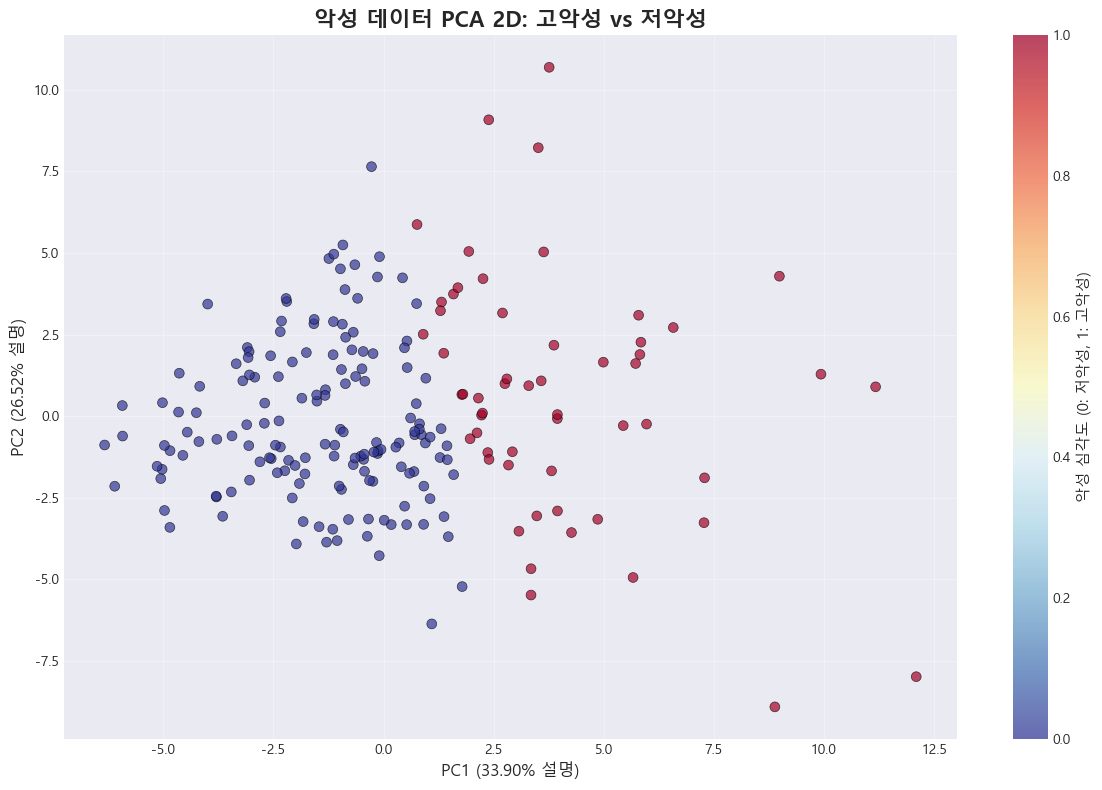


PC1에 가장 기여하는 특징 (상위 5개):
오목함 평균             0.286640
오목한 포인트 개수 평균      0.283640
치밀도 평균             0.250636
오목한 포인트 개수 최악상태    0.235646
둘레 길이 표준오차         0.226629
Name: PC1, dtype: float64

PC2에 가장 기여하는 특징 (상위 5개):
경계 불규칙성 평균      0.296937
경계 불규칙성 최악상태    0.286964
면적 평균           0.251686
반경 평균           0.251292
반경 최악상태         0.238450
Name: PC2, dtype: float64

✅ 시각화 4 완료: PCA 2D (고악성 vs 저악성)


In [38]:
# ============================================
# 블록 7. 시각화 4: PCA 차원 축소 & 악성 심각도 시각화
# ============================================

# 악성 데이터에 대해서만 PCA 수행
# PCA 2차원
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_malig_scaled)

expl_var1, expl_var2 = pca_2d.explained_variance_ratio_

# 악성 심각도별로 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    X_pca_2d[:, 0], 
    X_pca_2d[:, 1], 
    c=df_malignant["악성_심각도"].values, 
    s=50, 
    alpha=0.7,
    cmap="RdYlBu_r",
    edgecolors="black",
    linewidths=0.5
)
plt.xlabel(f"PC1 ({expl_var1:.2%} 설명)", fontsize=12)
plt.ylabel(f"PC2 ({expl_var2:.2%} 설명)", fontsize=12)
plt.title("악성 데이터 PCA 2D: 고악성 vs 저악성", fontsize=16, fontweight="bold")
cbar = plt.colorbar(scatter)
cbar.set_label("악성 심각도 (0: 저악성, 1: 고악성)", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# PC1, PC2에 기여하는 주요 특징 확인
pca_components = pd.DataFrame(
    pca_2d.components_.T,
    columns=["PC1", "PC2"],
    index=feature_cols
)

# PC1에 가장 기여하는 특징 상위 5개
print("\nPC1에 가장 기여하는 특징 (상위 5개):")
print(pca_components["PC1"].abs().sort_values(ascending=False).head(5))

# PC2에 가장 기여하는 특징 상위 5개
print("\nPC2에 가장 기여하는 특징 (상위 5개):")
print(pca_components["PC2"].abs().sort_values(ascending=False).head(5))

print("\n✅ 시각화 4 완료: PCA 2D (고악성 vs 저악성)")


## 블록 8: XAI 1 - Permutation Importance

**목적**: 악성 심각도 예측 모델에서 각 특징의 중요도 측정

**Permutation Importance란?**
- 특징 값을 무작위로 섞었을 때 모델 성능이 얼마나 감소하는지 측정
- 성능 감소가 클수록 해당 특징이 중요함을 의미
- 모델에 독립적인 특징 중요도 측정 방법

**결과 해석**:
- 상위 특징들이 악성 심각도(고악성/저악성) 구분에 가장 중요한 특징
- 이 특징들이 악성의 심각도에 가장 큰 영향을 미침


XAI 1: Permutation Importance (악성 심각도 예측 모델)

악성 심각도 예측에 가장 중요한 특징 (상위 10개):
                특징       중요도
0    오목한 포인트 개수 평균  0.017442
1           오목함 평균  0.016279
2  오목한 포인트 개수 최악상태  0.012791
3           치밀도 평균  0.012791
4       경계 불규칙성 평균  0.006977
5         치밀도 최악상태  0.006977
6            조직 평균  0.006977
7     경계 불규칙성 최악상태  0.005814
8          면적 표준오차  0.005814
9         오목함 최악상태  0.004651


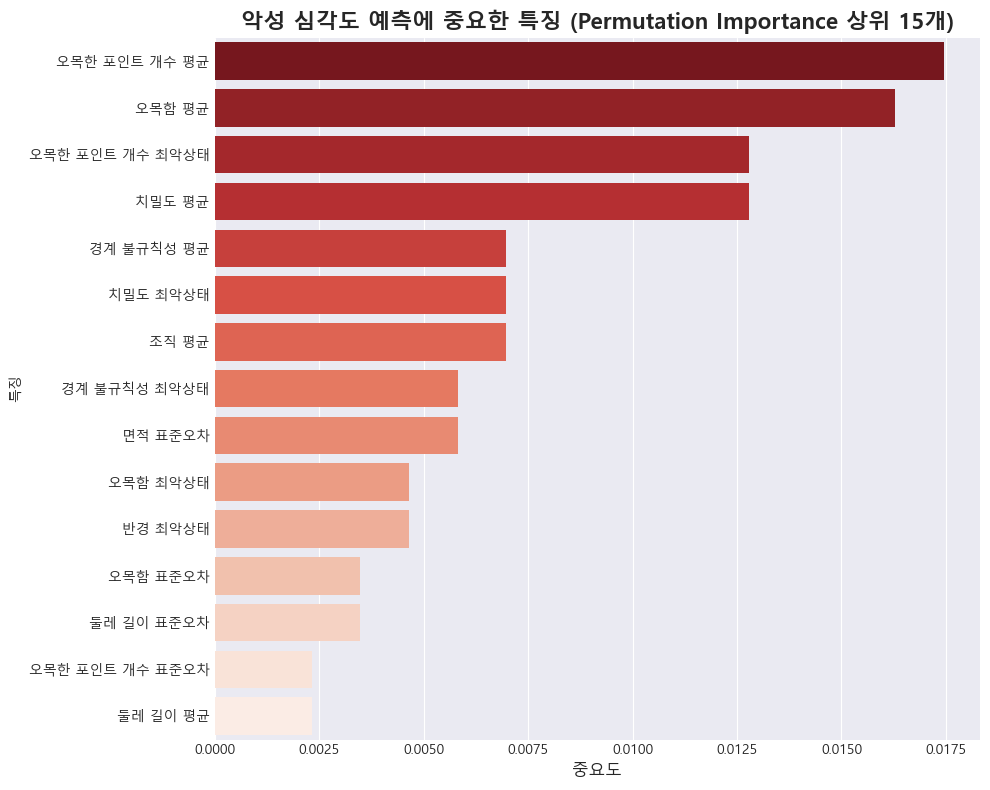


✅ XAI 1 완료: Permutation Importance
   → 악성 데이터 내에서 고악성/저악성을 구분하는 데 중요한 특징 파악


In [39]:
# ============================================
# 블록 8. XAI 1: Permutation Importance
# (악성 심각도 예측에 중요한 특징 분석)
# ============================================
print("=" * 70)
print("XAI 1: Permutation Importance (악성 심각도 예측 모델)")
print("=" * 70)

result = permutation_importance(
    rf_clf, X_test, y_test,
    n_repeats=20,
    random_state=42,
    n_jobs=-1
)

importances_mean = result.importances_mean
indices = np.argsort(importances_mean)[::-1]

feature_importance = pd.DataFrame({
    "특징": np.array(feature_cols)[indices],
    "중요도": importances_mean[indices]
})

print("\n악성 심각도 예측에 가장 중요한 특징 (상위 10개):")
print(feature_importance.head(10))

plt.figure(figsize=(10, 8))
sns.barplot(
    data=feature_importance.head(15),
    x="중요도",
    y="특징",
    orient="h",
    palette="Reds_r"
)
plt.title("악성 심각도 예측에 중요한 특징 (Permutation Importance 상위 15개)", 
          fontsize=16, fontweight="bold")
plt.xlabel("중요도", fontsize=12)
plt.tight_layout()
plt.show()

print("\n✅ XAI 1 완료: Permutation Importance")
print("   → 악성 데이터 내에서 고악성/저악성을 구분하는 데 중요한 특징 파악")


## 블록 9: XAI 2 - SHAP 분석

**목적**: 각 샘플에 대해 특징들이 고악성 예측에 얼마나 기여하는지 분석

**SHAP (SHapley Additive exPlanations)란?**
- 게임 이론의 Shapley 값을 기반으로 한 설명 방법
- 각 특징이 예측 결과에 기여하는 정도를 정량화
- 개별 샘플 단위로 특징 기여도 분석 가능

**시각화 내용**:
1. **요약 플롯 (Dot Plot)**: 
   - 특징별 SHAP 값의 분포
   - 색상: 특징 값의 크기 (빨간색=큰 값, 파란색=작은 값)
2. **바 플롯**: 
   - 평균 |SHAP 값| 기준 상위 특징들
   - 고악성 예측에 가장 기여하는 특징 순위

**인사이트**: 어떤 특징 값이 높을수록 고악성 예측에 기여하는지 확인


XAI 2: SHAP 분석 (악성 심각도 예측 모델)
✅ 한글 폰트 재설정: Malgun Gothic


SHAP 값 shape: (43, 30)
분석 대상: 고악성(1) 클래스에 대한 특징 기여도


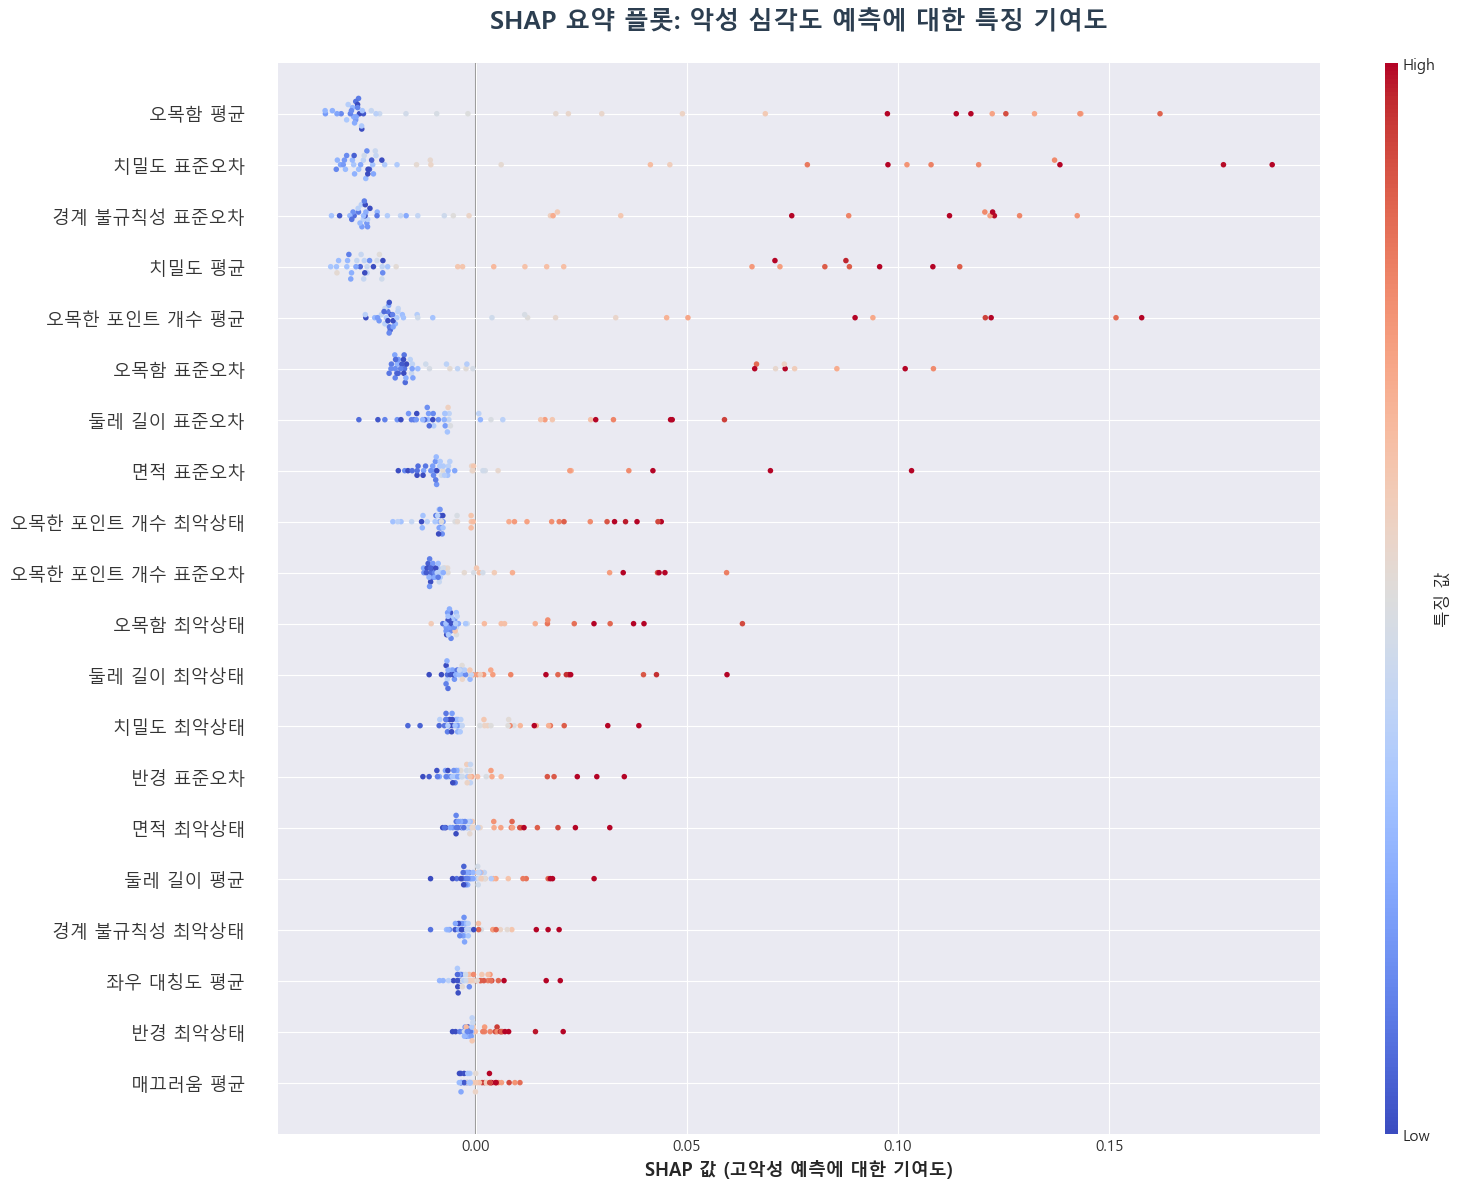

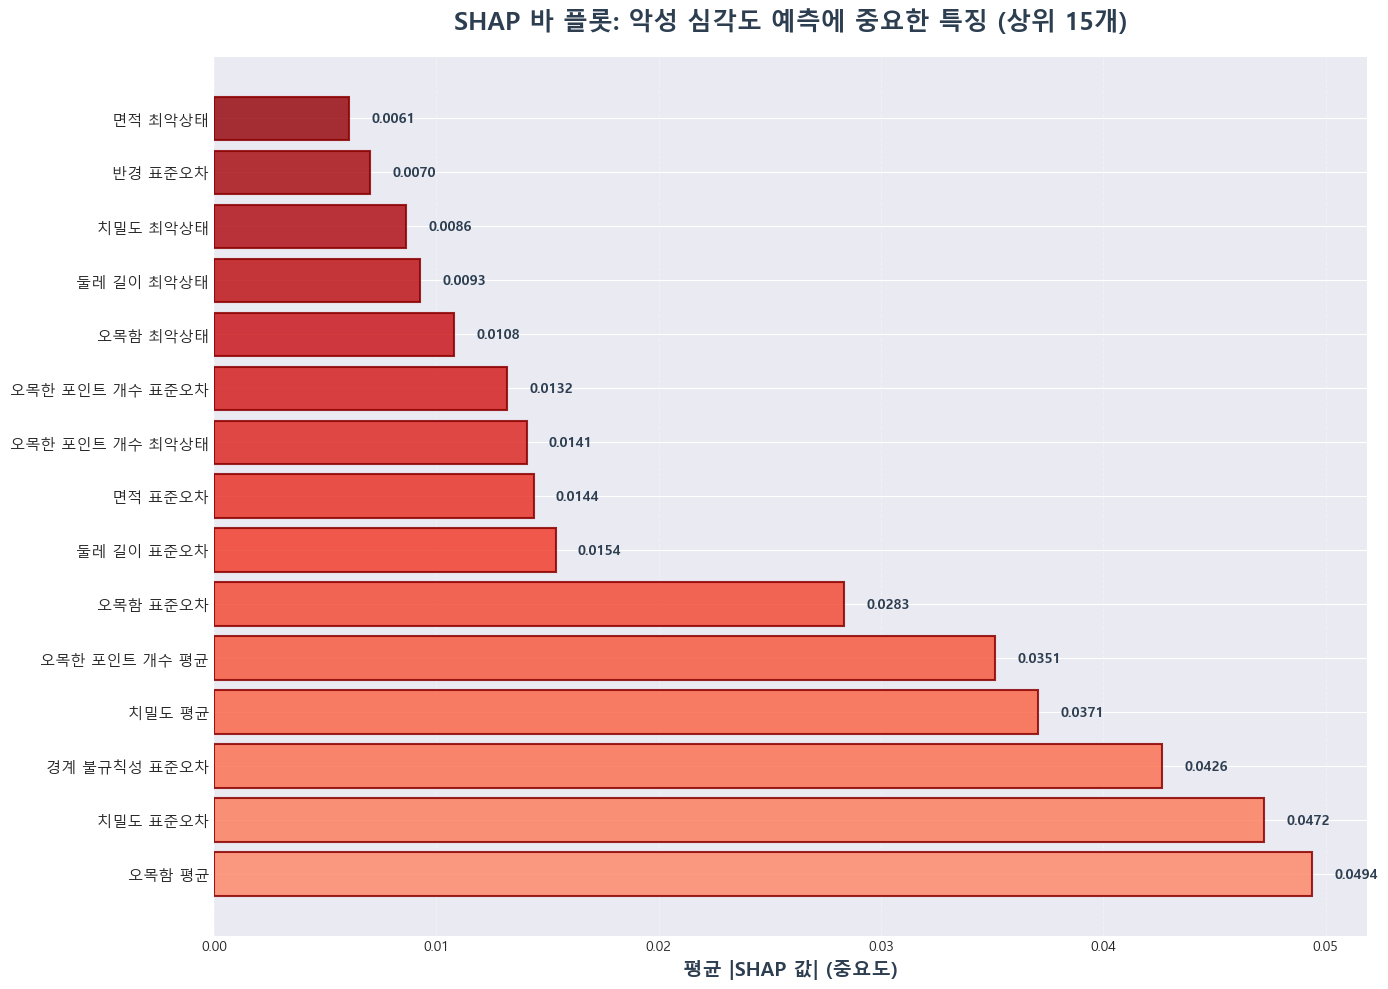


개별 샘플 SHAP 워터폴 플롯 (고악성 예측 상위 3개 샘플):


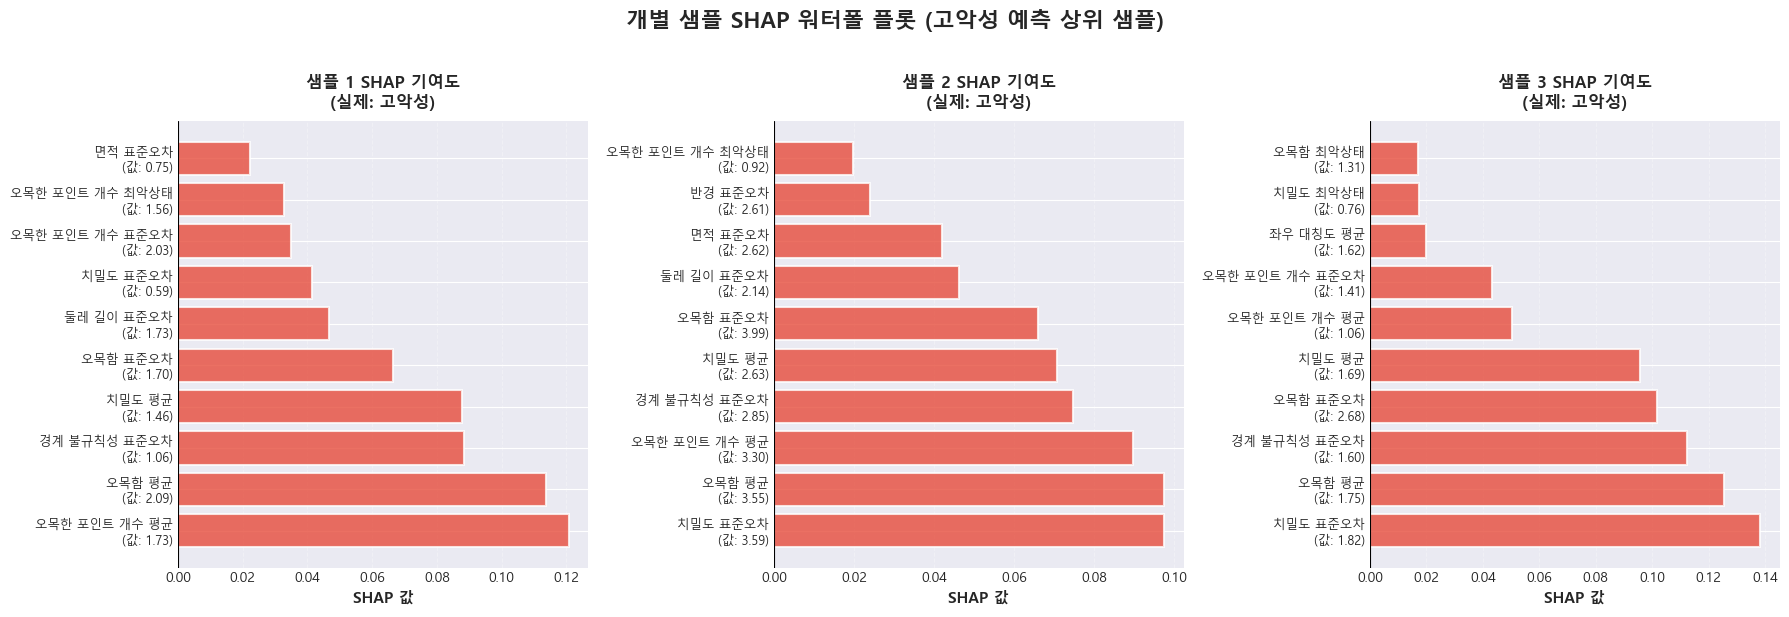

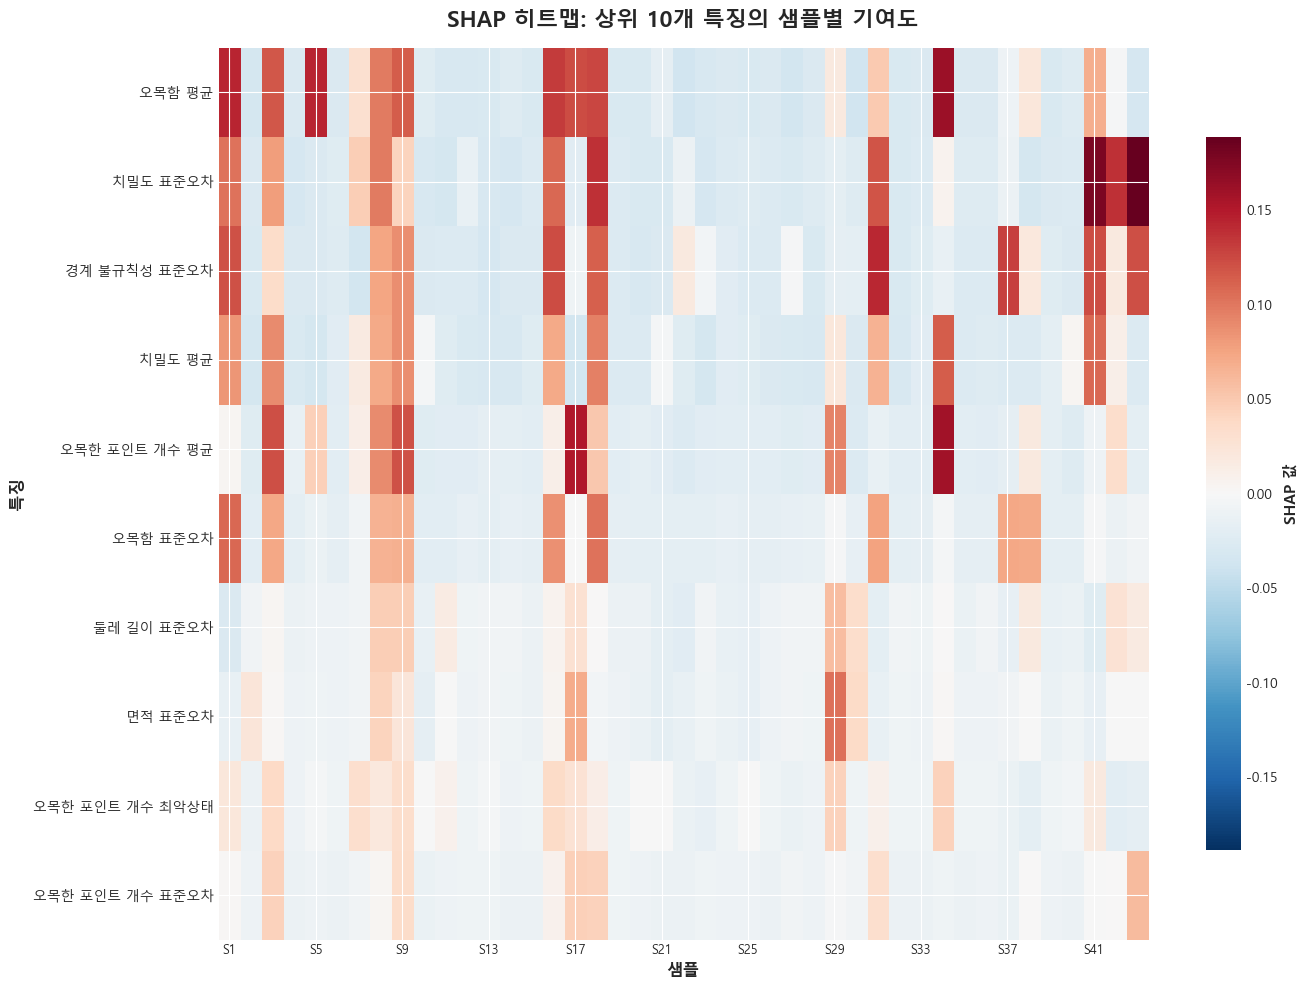


✅ XAI 2 완료: SHAP 요약/바/워터폴/히트맵 플롯
   → 각 특징이 고악성 예측에 얼마나 기여하는지 다각도로 분석


In [40]:
# ============================================
# 블록 9. XAI 2: SHAP 분석 (TreeExplainer)
# (악성 심각도 예측에 대한 특징 기여도 분석)
# ============================================
print("=" * 70)
print("XAI 2: SHAP 분석 (악성 심각도 예측 모델)")
print("=" * 70)

# 한글 폰트 재설정 (SHAP 플롯용)
try:
    font_names = [f.name for f in font_manager.fontManager.ttflist]
    if "Malgun Gothic" in font_names:
        plt.rcParams["font.family"] = "Malgun Gothic"
        print("✅ 한글 폰트 재설정: Malgun Gothic")
    elif "NanumGothic" in font_names:
        plt.rcParams["font.family"] = "NanumGothic"
        print("✅ 한글 폰트 재설정: NanumGothic")
    elif "AppleGothic" in font_names:
        plt.rcParams["font.family"] = "AppleGothic"
        print("✅ 한글 폰트 재설정: AppleGothic")
    else:
        plt.rcParams["font.family"] = "DejaVu Sans"
        print("⚠️ 한글 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
except Exception as e:
    print(f"⚠️ 폰트 설정 중 오류: {e}")

plt.rcParams["axes.unicode_minus"] = False

# SHAP 초기화 (Jupyter notebook용)
shap.initjs()

# 배경 데이터로 학습 데이터 일부 사용
X_background = X_train[np.random.choice(X_train.shape[0], size=min(100, X_train.shape[0]), replace=False)]

explainer = shap.TreeExplainer(rf_clf, data=X_background)
shap_values = explainer.shap_values(X_test)

# 이진 분류인 경우 shap_values는 [2, n_samples, n_features] 또는 (n_samples, n_features, 2)
# 1번 클래스(고악성) 기준으로 분석
if isinstance(shap_values, list):
    shap_values_pos = shap_values[1]  # 고악성 클래스에 대한 SHAP 값
elif len(shap_values.shape) == 3:
    # shape가 (n_samples, n_features, 2)인 경우
    shap_values_pos = shap_values[:, :, 1]  # 고악성 클래스
else:
    shap_values_pos = shap_values

print(f"SHAP 값 shape: {shap_values_pos.shape}")
print("분석 대상: 고악성(1) 클래스에 대한 특징 기여도")

# 샘플 일부만 사용해 시각화 (너무 많으면 렌더링 느림)
sample_size = min(100, X_test.shape[0])
sample_idx = np.random.choice(X_test.shape[0], size=sample_size, replace=False)
X_sample = X_test[sample_idx]
shap_sample = shap_values_pos[sample_idx]

# 스타일 설정 (호환성 처리)
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        try:
            plt.style.use('dark_background')
        except:
            plt.style.use('default')
sns.set_palette("husl")

# ============================================
# 1. 요약 플롯 (Dot Plot) - 개선된 버전
# ============================================
# 한글 폰트 강제 설정
plt.rcParams['font.family'] = 'Malgun Gothic' if 'Malgun Gothic' in [f.name for f in font_manager.fontManager.ttflist] else plt.rcParams['font.family']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(16, 12))
shap.summary_plot(
    shap_sample,
    X_sample,
    feature_names=feature_cols,
    show=False,
    max_display=20,
    plot_size=(16, 12),
    color_bar_label="특징 값",
    cmap=plt.get_cmap("coolwarm")
)
plt.title("SHAP 요약 플롯: 악성 심각도 예측에 대한 특징 기여도", 
          fontsize=18, fontweight="bold", pad=25, color='#2C3E50')
plt.xlabel("SHAP 값 (고악성 예측에 대한 기여도)", fontsize=13, fontweight="bold")
# y축 레이블 폰트 설정
ax = plt.gca()
for label in ax.get_yticklabels():
    label.set_fontfamily(plt.rcParams['font.family'])
plt.subplots_adjust(left=0.28, right=0.95, top=0.94, bottom=0.08)
plt.tight_layout()
plt.show()

# ============================================
# 2. 바 플롯 - 개선된 버전
# ============================================
# SHAP 값의 평균 절댓값 계산
shap_abs_mean = np.abs(shap_sample).mean(0)
feature_importance_shap = pd.DataFrame({
    '특징': feature_cols,
    '중요도': shap_abs_mean
}).sort_values('중요도', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(14, 10))
colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(feature_importance_shap)))
bars = ax.barh(
    range(len(feature_importance_shap)),
    feature_importance_shap['중요도'].values,
    color=colors,
    edgecolor='darkred',
    linewidth=1.5,
    alpha=0.85
)

# 값 표시
for i, (idx, row) in enumerate(feature_importance_shap.iterrows()):
    ax.text(row['중요도'] + 0.001, i, f'{row["중요도"]:.4f}', 
            va='center', fontsize=10, fontweight='bold', color='#2C3E50')

ax.set_yticks(range(len(feature_importance_shap)))
# 한글 폰트 설정
yticklabels = ax.set_yticklabels(feature_importance_shap['특징'].values, fontsize=11)
for label in yticklabels:
    label.set_fontfamily(plt.rcParams['font.family'])
ax.set_xlabel('평균 |SHAP 값| (중요도)', fontsize=14, fontweight="bold", color='#2C3E50')
ax.set_title('SHAP 바 플롯: 악성 심각도 예측에 중요한 특징 (상위 15개)', 
             fontsize=18, fontweight="bold", pad=20, color='#2C3E50')
ax.grid(True, alpha=0.3, linestyle='--', axis='x')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#BDC3C7')
ax.spines['bottom'].set_color('#BDC3C7')
plt.tight_layout()
plt.show()

# ============================================
# 3. 워터폴 플롯 (개별 샘플 설명) - 상위 3개 샘플
# ============================================
print("\n개별 샘플 SHAP 워터폴 플롯 (고악성 예측 상위 3개 샘플):")

# 고악성으로 예측된 샘플 중 SHAP 합이 큰 순서로 정렬
high_malig_indices = np.where(y_test[sample_idx] == 1)[0]
if len(high_malig_indices) > 0:
    shap_sums = shap_sample[high_malig_indices].sum(axis=1)
    top_indices = high_malig_indices[np.argsort(shap_sums)[-3:][::-1]]
    
    num_plots = min(3, len(top_indices))
    fig, axes = plt.subplots(1, num_plots, figsize=(18, 6))
    if num_plots == 1:
        axes = [axes]
    
    for plot_idx, sample_idx_in_array in enumerate(top_indices):
        if plot_idx >= num_plots:
            break
        ax = axes[plot_idx]
        
        # 워터폴 스타일 플롯 생성
        sample_shap = shap_sample[sample_idx_in_array]
        sample_values = X_sample[sample_idx_in_array]
        
        # SHAP 값 기준으로 정렬
        sorted_idx = np.argsort(np.abs(sample_shap))[::-1][:10]  # 상위 10개만
        
        y_pos = np.arange(len(sorted_idx))
        colors_waterfall = ['#E74C3C' if sample_shap[i] > 0 else '#3498DB' for i in sorted_idx]
        
        bars = ax.barh(y_pos, sample_shap[sorted_idx], color=colors_waterfall, 
                       edgecolor='white', linewidth=1.5, alpha=0.8)
        
        # 특징 이름과 값 표시
        labels = [f"{feature_cols[i]}\n(값: {sample_values[i]:.2f})" for i in sorted_idx]
        ax.set_yticks(y_pos)
        yticklabels = ax.set_yticklabels(labels, fontsize=9)
        # 한글 폰트 설정
        for label in yticklabels:
            label.set_fontfamily(plt.rcParams['font.family'])
        ax.set_xlabel('SHAP 값', fontsize=11, fontweight="bold")
        actual_label = "고악성" if y_test[sample_idx[sample_idx_in_array]] == 1 else "저악성"
        ax.set_title(f'샘플 {plot_idx+1} SHAP 기여도\n(실제: {actual_label})', 
                     fontsize=12, fontweight="bold", pad=10)
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        ax.grid(True, alpha=0.3, linestyle='--', axis='x')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.suptitle('개별 샘플 SHAP 워터폴 플롯 (고악성 예측 상위 샘플)', 
                 fontsize=16, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("   고악성 샘플이 없어 워터폴 플롯을 생성하지 않습니다.")

# ============================================
# 4. 히트맵 스타일 SHAP 플롯 (선택적)
# ============================================
# 상위 특징들에 대한 히트맵
top_features_shap = feature_importance_shap.head(10)['특징'].values
top_feature_indices = [feature_cols.index(f) for f in top_features_shap]

shap_heatmap_data = shap_sample[:, top_feature_indices]

fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(shap_heatmap_data.T, aspect='auto', cmap='RdBu_r', 
               interpolation='nearest', vmin=-np.abs(shap_heatmap_data).max(), 
               vmax=np.abs(shap_heatmap_data).max())

ax.set_xticks(range(0, len(shap_heatmap_data), max(1, len(shap_heatmap_data)//10)))
ax.set_xticklabels([f'S{i+1}' for i in range(0, len(shap_heatmap_data), max(1, len(shap_heatmap_data)//10))], 
                    fontsize=9)
ax.set_yticks(range(len(top_features_shap)))
yticklabels = ax.set_yticklabels(top_features_shap, fontsize=10)
# 한글 폰트 설정
for label in yticklabels:
    label.set_fontfamily(plt.rcParams['font.family'])
ax.set_xlabel('샘플', fontsize=12, fontweight="bold")
ax.set_ylabel('특징', fontsize=12, fontweight="bold")
ax.set_title('SHAP 히트맵: 상위 10개 특징의 샘플별 기여도', 
             fontsize=16, fontweight="bold", pad=15)

cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('SHAP 값', fontsize=11, fontweight="bold")
plt.tight_layout()
plt.show()

print("\n✅ XAI 2 완료: SHAP 요약/바/워터폴/히트맵 플롯")
print("   → 각 특징이 고악성 예측에 얼마나 기여하는지 다각도로 분석")


## 블록 10: XAI 3 - Partial Dependence Plot (PDP) & ICE

**목적**: 특징 값의 변화가 고악성 예측 확률에 미치는 영향을 시각화

**PDP (Partial Dependence Plot)란?**
- 특정 특징의 값이 변할 때 예측 확률이 어떻게 변하는지 보여줌
- 다른 특징들은 평균값으로 고정하고 분석 특징만 변화시킴

**ICE (Individual Conditional Expectation)란?**
- 각 샘플별로 특징 값 변화에 따른 예측 확률 변화
- PDP는 ICE들의 평균

**인사이트**:
- 특징 값이 증가할수록 고악성 예측 확률이 증가하는지 감소하는지 확인
- 특징과 악성 심각도 간의 관계 형태 파악 (선형/비선형)


XAI 3: PDP & ICE (악성 심각도 예측 모델)
PDP/ICE에 사용할 상위 특징 (악성 심각도 예측에 가장 중요한 특징): ['오목한 포인트 개수 평균', '오목함 평균', '오목한 포인트 개수 최악상태']


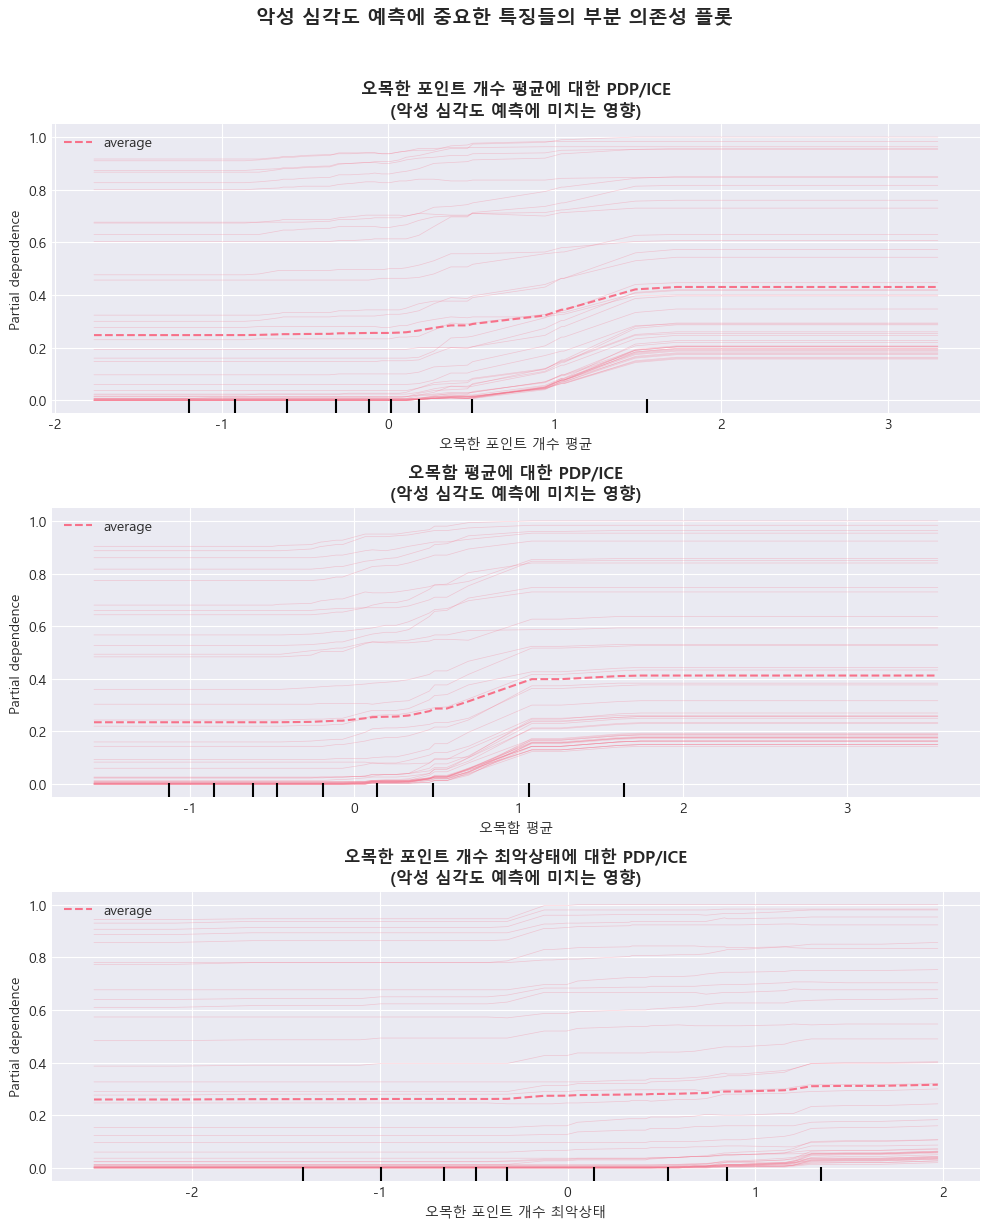


✅ XAI 3 완료: PDP & ICE
   → 각 특징 값의 변화가 고악성 예측 확률에 미치는 영향 분석


In [41]:
# ============================================
# 블록 10. XAI 3: Partial Dependence Plot & ICE
# (악성 심각도 예측에 대한 특징별 영향력 분석)
# ============================================
print("=" * 70)
print("XAI 3: PDP & ICE (악성 심각도 예측 모델)")
print("=" * 70)

# Permutation importance에서 상위 3개 특징만 사용
top_features = list(feature_importance["특징"].head(3))
print("PDP/ICE에 사용할 상위 특징 (악성 심각도 예측에 가장 중요한 특징):", top_features)

fig, ax = plt.subplots(len(top_features), 1, figsize=(10, 4 * len(top_features)))

if len(top_features) == 1:
    ax = [ax]

for i, feat in enumerate(top_features):
    PartialDependenceDisplay.from_estimator(
        rf_clf,
        X_test,
        [feature_cols.index(feat)],
        feature_names=feature_cols,
        kind="both",  # PDP + ICE
        ax=ax[i]
    )
    ax[i].set_title(f"{feat}에 대한 PDP/ICE\n(악성 심각도 예측에 미치는 영향)", 
                    fontsize=12, fontweight="bold")
    ax[i].set_ylabel("고악성 예측 확률", fontsize=10)

plt.suptitle("악성 심각도 예측에 중요한 특징들의 부분 의존성 플롯", 
             fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

print("\n✅ XAI 3 완료: PDP & ICE")
print("   → 각 특징 값의 변화가 고악성 예측 확률에 미치는 영향 분석")


## 블록 11: 분석 결과 통합 요약

**최종 분석 결과 요약**

이 블록에서는 앞서 수행한 모든 분석의 결과를 통합하여 정리합니다.

**주요 결과**:
1. **Permutation Importance 상위 특징**: 악성 심각도 예측에 가장 중요한 특징들
2. **PCA 설명 분산**: 차원 축소 후 정보 보존 정도
3. **상관관계 상위 특징**: 악성 심각도와 직접적인 상관관계가 높은 특징들
4. **모델 성능**: 고악성/저악성 구분 정확도

**최종 인사이트**: 
- 악성 데이터 내에서 어떤 특징이 악성의 심각도에 가장 큰 영향을 주는지 종합적으로 파악


In [42]:
# ============================================
# 블록 11. XAI 4: 간단 통합 비교 & 분석 요약
# ============================================
print("=" * 70)
print("악성 심각도 분석 통합 요약")
print("=" * 70)

print("\n【분석 목표】")
print("   악성 데이터 내에서 어떤 특징이 악성 심각도(고악성/저악성)에 가장 영향을 주는지 분석")

print("\n【데이터 정보】")
print(f"   - 전체 악성 데이터 개수: {len(df_malignant)}개")
print(f"   - 고악성 (1): {df_malignant['악성_심각도'].sum()}개")
print(f"   - 저악성 (0): {(df_malignant['악성_심각도'] == 0).sum()}개")

print("\n【1. 악성 심각도 예측에 가장 중요한 특징 (Permutation Importance 상위 5개)】")
for i, row in feature_importance.head(5).iterrows():
    print(f"   {i+1}. {row['특징']} (중요도: {row['중요도']:.4f})")

print("\n【2. PCA 2D에서 설명 분산 비율】")
print(f"   - PC1: {expl_var1:.2%}")
print(f"   - PC2: {expl_var2:.2%}")
print(f"   - 누적: {(expl_var1 + expl_var2):.2%}")

print("\n【3. 악성 심각도와 상관관계가 높은 특징 (상위 5개)】")
top_corr_features = malig_severity_corr.abs().sort_values(ascending=False).head(5)
for i, (feat, corr) in enumerate(top_corr_features.items(), 1):
    print(f"   {i}. {feat} (상관계수: {corr:.4f})")

print("\n【4. 모델 성능】")
print(f"   - 정확도: {accuracy_score(y_test, y_pred):.4f}")

print("\n" + "=" * 70)
print("✅ 분석 완료!")
print("   → 악성 데이터 내에서 고악성/저악성을 구분하는 데 중요한 특징들을 파악했습니다.")
print("   → 상위 특징들이 악성의 심각도에 가장 큰 영향을 미치는 것으로 분석됩니다.")
print("=" * 70)


악성 심각도 분석 통합 요약

【분석 목표】
   악성 데이터 내에서 어떤 특징이 악성 심각도(고악성/저악성)에 가장 영향을 주는지 분석

【데이터 정보】
   - 전체 악성 데이터 개수: 212개
   - 고악성 (1): 56개
   - 저악성 (0): 156개

【1. 악성 심각도 예측에 가장 중요한 특징 (Permutation Importance 상위 5개)】
   1. 오목한 포인트 개수 평균 (중요도: 0.0174)
   2. 오목함 평균 (중요도: 0.0163)
   3. 오목한 포인트 개수 최악상태 (중요도: 0.0128)
   4. 치밀도 평균 (중요도: 0.0128)
   5. 경계 불규칙성 평균 (중요도: 0.0070)

【2. PCA 2D에서 설명 분산 비율】
   - PC1: 33.90%
   - PC2: 26.52%
   - 누적: 60.42%

【3. 악성 심각도와 상관관계가 높은 특징 (상위 5개)】
   1. 오목함 평균 (상관계수: 0.7172)
   2. 치밀도 평균 (상관계수: 0.6937)
   3. 오목한 포인트 개수 평균 (상관계수: 0.6591)
   4. 치밀도 표준오차 (상관계수: 0.6401)
   5. 오목함 표준오차 (상관계수: 0.6259)

【4. 모델 성능】
   - 정확도: 0.9535

✅ 분석 완료!
   → 악성 데이터 내에서 고악성/저악성을 구분하는 데 중요한 특징들을 파악했습니다.
   → 상위 특징들이 악성의 심각도에 가장 큰 영향을 미치는 것으로 분석됩니다.
